# Potential Advantages of Ensembling Random Forests

In this notebook we will explore possible advantages of Ensembling Random Forests. This will be done both in a theoretical and practcal way.

This notebook demonstrates the advantages of ensembling multiple Random Forests
from the perspective of uncertainty quantification, inspired by the probly library.

Structure:
1. Introduction & Theoretical Background
2. Data Generation & Setup
3. Single Random Forest vs Ensemble Analysis
4. Uncertainty Decomposition (Aleatoric vs Epistemic)
5. Calibration Analysis
7. Performance Comparison
8. Conclusions

## 1. Import & Setup

In [28]:
!{sys.executable} -m pip install seaborn


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip3 install --upgrade pip


In [ ]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

warnings.filterwarnings("ignore")

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["font.size"] = 10

np.random.seed(42)

# 2. Theoretical Background

Uncertainty in Machine Learning is generally viewed from two perspectives:

1. ALEATORIC UNCERTAINTY (Data Uncertainty)
   - Inherent randomness in the data
   - Cannot be reduced by collecting more data
   - Example: Noise in measurements

2. EPISTEMIC UNCERTAINTY (Model Uncertainty)
   - Uncertainty about the model itself
   - CAN be reduced with more data or better models
   - Example: Limited training data, model limitations

WHY ENSEMBLE RANDOM FORESTS?

Random Forests are already ensemble models (of decision trees), but if we ensemble Random Forests, we can hope for improvements in second-order uncertainty, better uncertainty decomposition and more. 

# 3. Data Generation

✓ Generated 1000 samples with heteroscedastic noise
  - Training samples: 700
  - Test samples: 300
  - Feature dimensions: 2


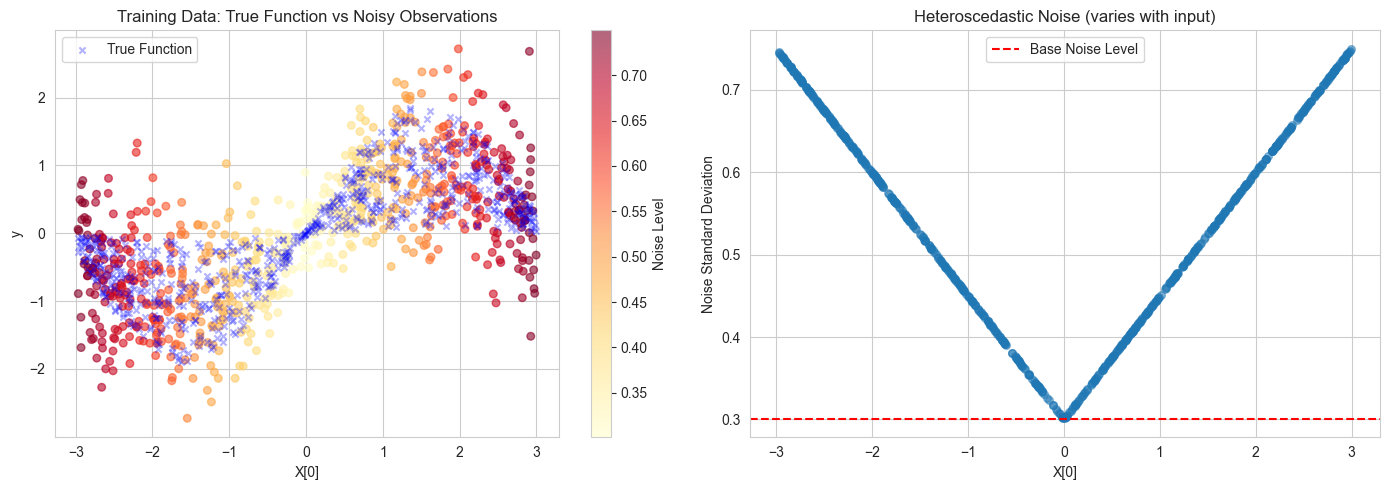

In [ ]:
def generate_heteroscedastic_data(n_samples: int = 1000, noise_level: int = 0.3):  # noqa: ANN201
    """Generate regression data with heteroscedastic noise (noise that varies across the input space)."""
    X = np.random.uniform(-3, 3, (n_samples, 2))  # noqa: N806

    y_true = np.sin(X[:, 0]) * (1 + 0.3 * X[:, 1])

    noise_std = noise_level * (1 + 0.5 * np.abs(X[:, 0]))
    noise = np.random.normal(0, noise_std)

    y = y_true + noise

    return X, y, y_true, noise_std


# Generate data
X, y, y_true, true_noise = generate_heteroscedastic_data(n_samples=1000)
X_train, X_test, y_train, y_test, ytrue_train, ytrue_test, noise_train, noise_test = train_test_split(
    X,
    y,
    y_true,
    true_noise,
    test_size=0.3,
    random_state=42,
)

print(f"✓ Generated {len(X)} samples with heteroscedastic noise")
print(f"  - Training samples: {len(X_train)}")
print(f"  - Test samples: {len(X_test)}")
print(f"  - Feature dimensions: {X.shape[1]}")

# Visualize the data
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: True function and noisy observations
scatter = axes[0].scatter(X_train[:, 0], y_train, c=noise_train, cmap="YlOrRd", alpha=0.6, s=30)
axes[0].scatter(X_train[:, 0], ytrue_train, c="blue", marker="x", s=20, label="True Function", alpha=0.3)
axes[0].set_xlabel("X[0]")
axes[0].set_ylabel("y")
axes[0].set_title("Training Data: True Function vs Noisy Observations")
axes[0].legend()
plt.colorbar(scatter, ax=axes[0], label="Noise Level")

# Plot 2: Noise distribution across input space
axes[1].scatter(X_train[:, 0], noise_train, alpha=0.5, s=30)
axes[1].set_xlabel("X[0]")
axes[1].set_ylabel("Noise Standard Deviation")
axes[1].set_title("Heteroscedastic Noise (varies with input)")
axes[1].axhline(y=0.3, color="r", linestyle="--", label="Base Noise Level")
axes[1].legend()

plt.tight_layout()
plt.show()

# 4. Random Forest Ensemble Prototype

In [ ]:
class RandomForestEnsemble:
    """Ensemble of Random Forests for uncertainty quantification."""

    def __init__(self, n_members: int = 5, n_estimators: int = 50, random_state: int = 42) -> None:
        """Initialize an ensemble of Random Forests."""
        self.n_members = n_members
        self.n_estimators = n_estimators
        self.random_state = random_state
        self.forests = []

    def fit(self, X, y) -> None:  # noqa: ANN001, N803
        """Train multiple Random Forests with different random seeds."""
        print(f"Training ensemble of {self.n_members} Random Forests...")
        for i in range(self.n_members):
            rf = RandomForestRegressor(
                n_estimators=self.n_estimators,
                max_depth=10,
                random_state=self.random_state + i,
                n_jobs=-1,
            )
            rf.fit(X, y)
            self.forests.append(rf)
        print(f"✓ Trained {len(self.forests)} Random Forests")

    def predict(self, X, return_individual=False) -> None:  # noqa: ANN001, N803
        """Predict with uncertainty quantification.

        Returns:
        - mean: Mean prediction across ensemble
        - epistemic_std: Standard deviation across forests (epistemic uncertainty)
        - aleatoric_std: Average std within each forest (aleatoric uncertainty)
        """
        predictions = np.array([rf.predict(X) for rf in self.forests])

        mean_pred = np.mean(predictions, axis=0)
        epistemic_uncertainty = np.std(predictions, axis=0)

        aleatoric_uncertainties = []
        for rf in self.forests:
            tree_preds = np.array([tree.predict(X) for tree in rf.estimators_])
            aleatoric_uncertainties.append(np.std(tree_preds, axis=0))
        aleatoric_uncertainty = np.mean(aleatoric_uncertainties, axis=0)

        if return_individual:
            return mean_pred, epistemic_uncertainty, aleatoric_uncertainty, predictions
        return mean_pred, epistemic_uncertainty, aleatoric_uncertainty


single_rf = RandomForestRegressor(
    n_estimators=250,
    max_depth=10,
    random_state=42,
    n_jobs=-1,
)
single_rf.fit(X_train, y_train)

rf_ensemble = RandomForestEnsemble(n_members=5, n_estimators=50, random_state=42)
rf_ensemble.fit(X_train, y_train)

Training ensemble of 5 Random Forests...
✓ Trained 5 Random Forests


# 5. Uncertainty Analysis


Uncertainty Statistics:
  Mean Epistemic Uncertainty: 0.0539
  Mean Aleatoric Uncertainty: 0.4276
  Mean Total Uncertainty: 0.4313
  Epistemic / Total Ratio: 12.26%


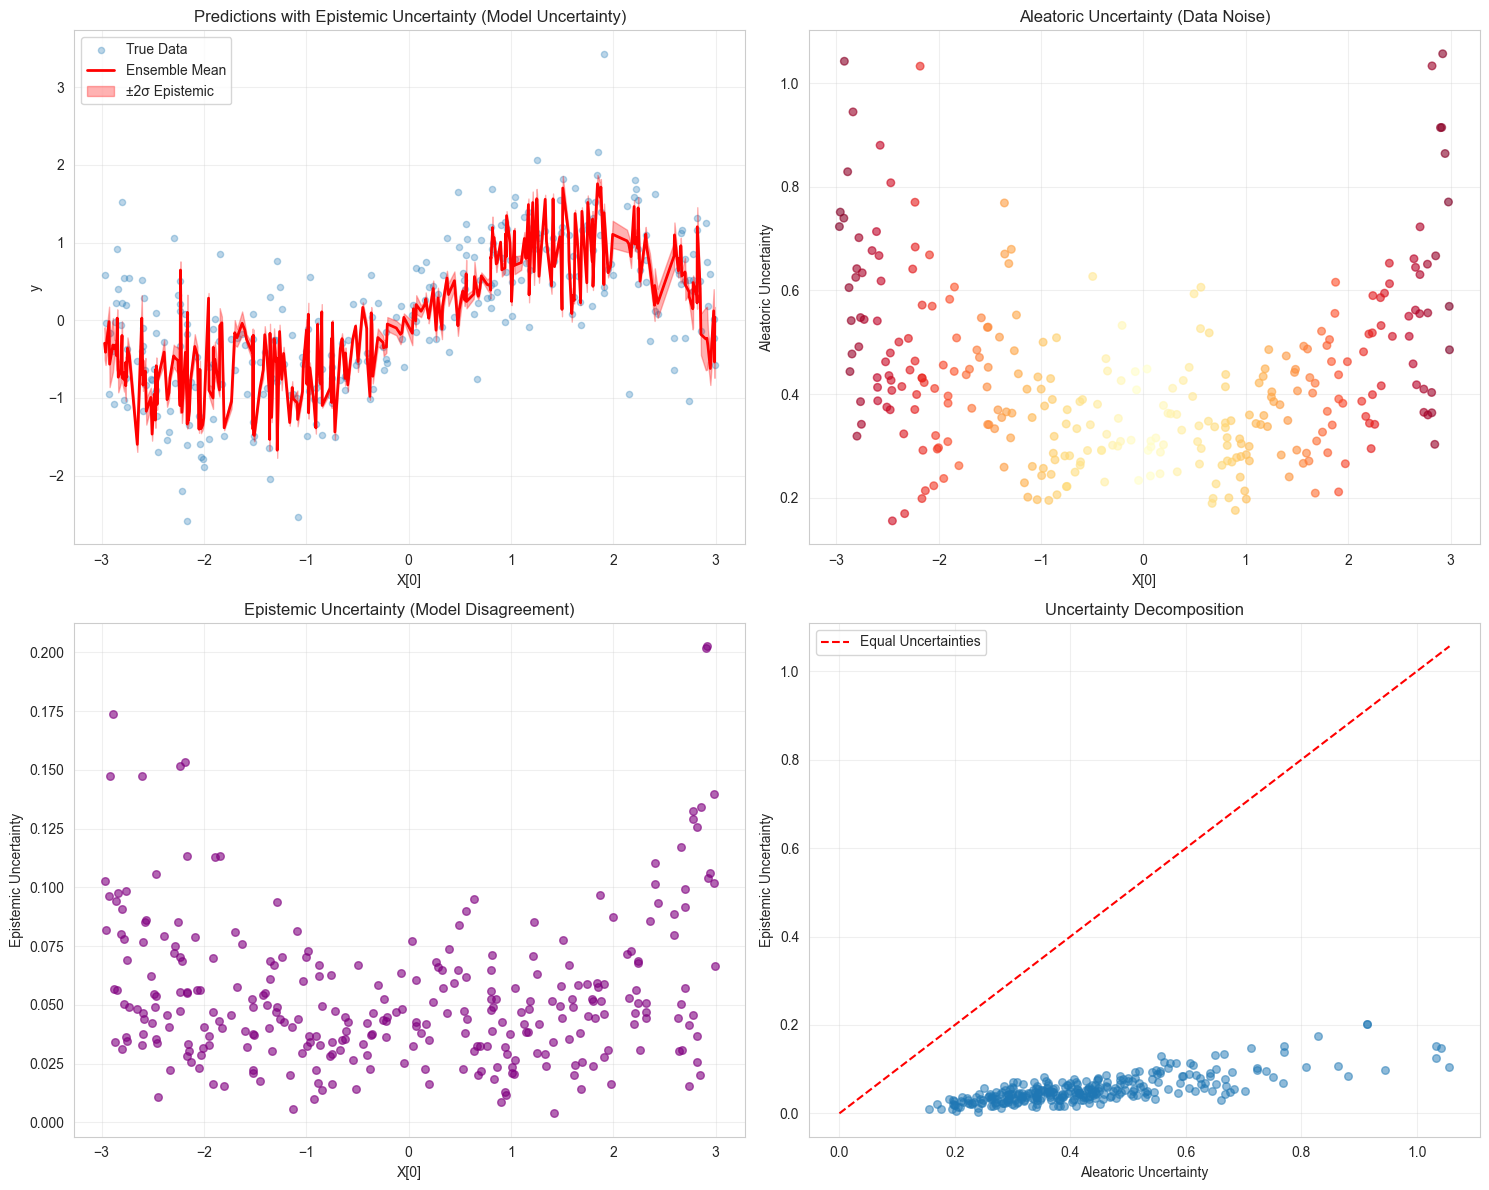

In [ ]:
# Get predictions
y_pred_single = single_rf.predict(X_test)
y_pred_ensemble, epistemic_unc, aleatoric_unc = rf_ensemble.predict(X_test)

# Calculate total uncertainty
total_unc = np.sqrt(epistemic_unc**2 + aleatoric_unc**2)

print("\nUncertainty Statistics:")
print(f"  Mean Epistemic Uncertainty: {np.mean(epistemic_unc):.4f}")
print(f"  Mean Aleatoric Uncertainty: {np.mean(aleatoric_unc):.4f}")
print(f"  Mean Total Uncertainty: {np.mean(total_unc):.4f}")
print(f"  Epistemic / Total Ratio: {np.mean(epistemic_unc / total_unc):.2%}")

# Visualize uncertainty decomposition
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Predictions with epistemic uncertainty
sorted_idx = np.argsort(X_test[:, 0])
axes[0, 0].scatter(X_test[:, 0], y_test, alpha=0.3, s=20, label="True Data")
axes[0, 0].plot(X_test[sorted_idx, 0], y_pred_ensemble[sorted_idx], "r-", linewidth=2, label="Ensemble Mean")
axes[0, 0].fill_between(
    X_test[sorted_idx, 0],
    y_pred_ensemble[sorted_idx] - 2 * epistemic_unc[sorted_idx],
    y_pred_ensemble[sorted_idx] + 2 * epistemic_unc[sorted_idx],
    alpha=0.3,
    label="±2σ Epistemic",  # noqa: RUF001
    color="red",
)
axes[0, 0].set_xlabel("X[0]")
axes[0, 0].set_ylabel("y")
axes[0, 0].set_title("Predictions with Epistemic Uncertainty (Model Uncertainty)")
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Aleatoric uncertainty
axes[0, 1].scatter(X_test[:, 0], aleatoric_unc, alpha=0.6, s=30, c=noise_test, cmap="YlOrRd")
axes[0, 1].set_xlabel("X[0]")
axes[0, 1].set_ylabel("Aleatoric Uncertainty")
axes[0, 1].set_title("Aleatoric Uncertainty (Data Noise)")
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Epistemic uncertainty
axes[1, 0].scatter(X_test[:, 0], epistemic_unc, alpha=0.6, s=30, color="purple")
axes[1, 0].set_xlabel("X[0]")
axes[1, 0].set_ylabel("Epistemic Uncertainty")
axes[1, 0].set_title("Epistemic Uncertainty (Model Disagreement)")
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Uncertainty decomposition
axes[1, 1].scatter(aleatoric_unc, epistemic_unc, alpha=0.5, s=30)
axes[1, 1].plot([0, max(aleatoric_unc)], [0, max(aleatoric_unc)], "r--", label="Equal Uncertainties")
axes[1, 1].set_xlabel("Aleatoric Uncertainty")
axes[1, 1].set_ylabel("Epistemic Uncertainty")
axes[1, 1].set_title("Uncertainty Decomposition")
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 6. Performance Metrics


Predictive Performance:
------------------------------------------------------------
Single RF RMSE: 0.5788
Ensemble RMSE: 0.5769
Improvement: 0.67%

Uncertainty-Aware Performance:
------------------------------------------------------------
Predictions within 1σ: 56.67% (theoretical: 68.3%)
Predictions within 2σ: 87.33% (theoretical: 95.4%)


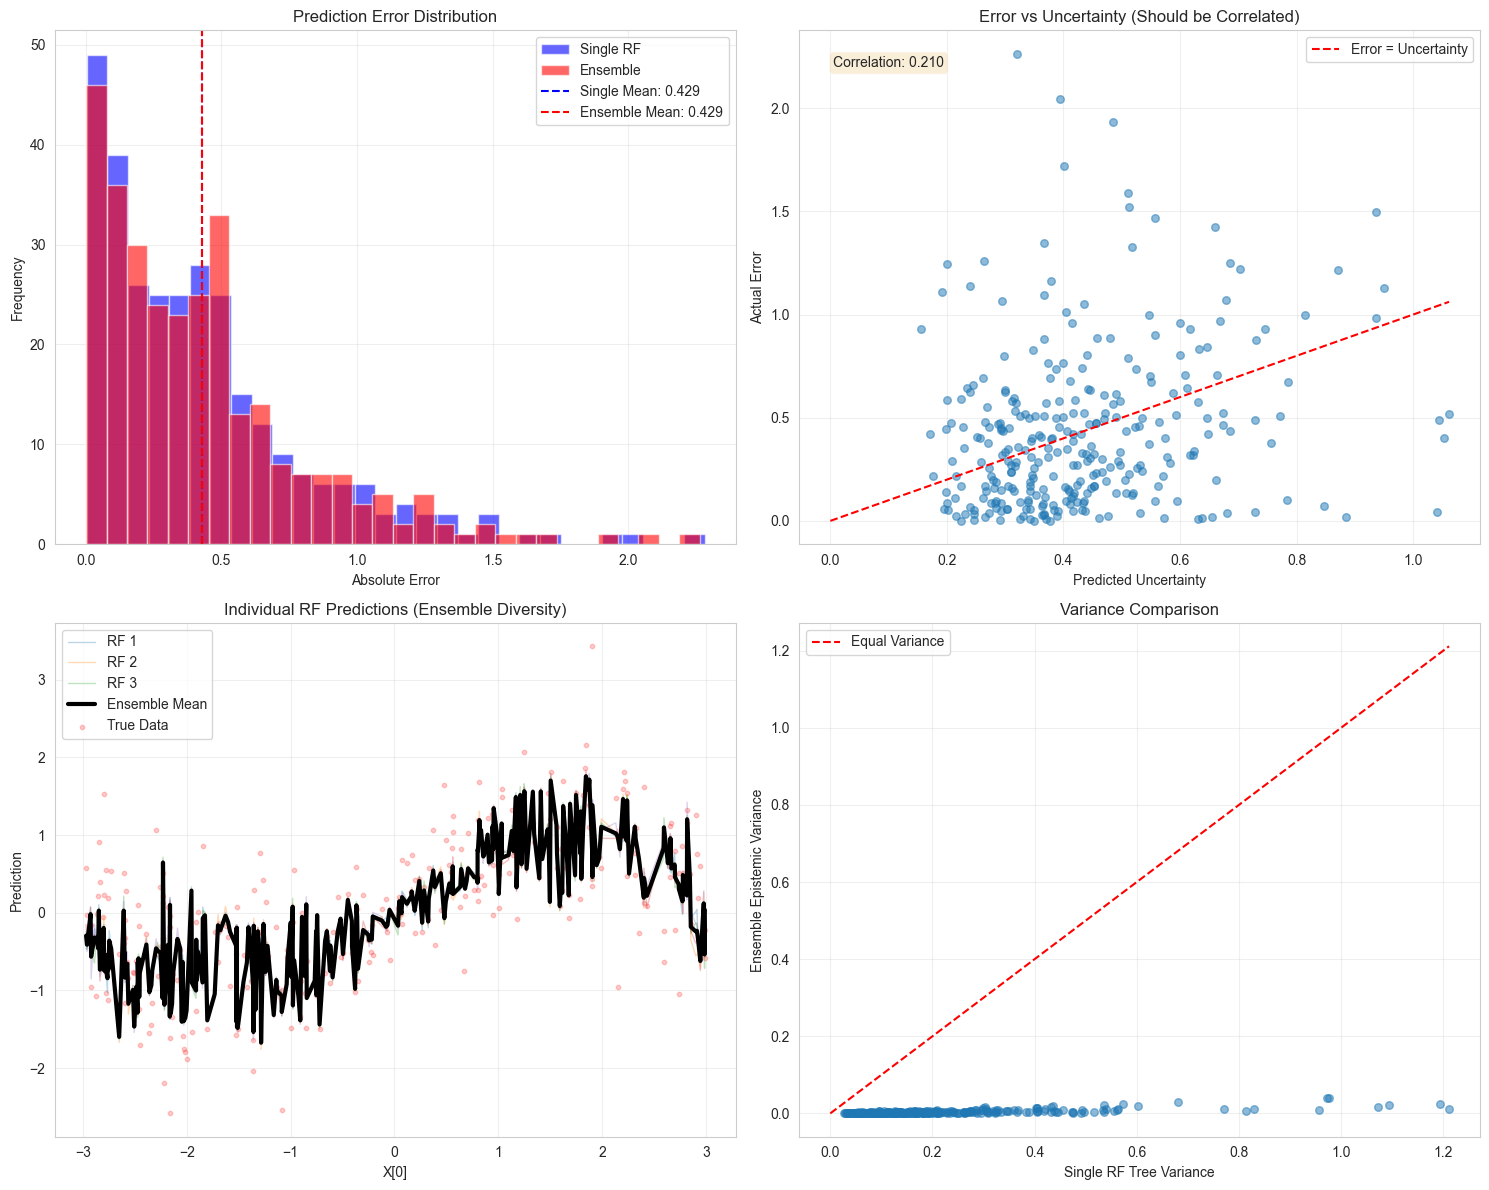

In [ ]:
mse_single = mean_squared_error(y_test, y_pred_single)
mse_ensemble = mean_squared_error(y_test, y_pred_ensemble)
rmse_single = np.sqrt(mse_single)
rmse_ensemble = np.sqrt(mse_ensemble)

within_1sigma = np.mean(np.abs(y_test - y_pred_ensemble) <= total_unc)
within_2sigma = np.mean(np.abs(y_test - y_pred_ensemble) <= 2 * total_unc)

print("\nPredictive Performance:")
print("-" * 60)
print(f"Single RF RMSE: {rmse_single:.4f}")
print(f"Ensemble RMSE: {rmse_ensemble:.4f}")
print(f"Improvement: {(1 - mse_ensemble / mse_single) * 100:.2f}%")

print("\nUncertainty-Aware Performance:")
print("-" * 60)
print(f"Predictions within 1σ: {within_1sigma:.2%} (theoretical: 68.3%)")  # noqa: RUF001
print(f"Predictions within 2σ: {within_2sigma:.2%} (theoretical: 95.4%)")  # noqa: RUF001

# Visualize performance comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Prediction errors
errors_single = np.abs(y_test - y_pred_single)
errors_ensemble = np.abs(y_test - y_pred_ensemble)

axes[0, 0].hist(errors_single, bins=30, alpha=0.6, label="Single RF", color="blue")
axes[0, 0].hist(errors_ensemble, bins=30, alpha=0.6, label="Ensemble", color="red")
axes[0, 0].axvline(
    np.mean(errors_single),
    color="blue",
    linestyle="--",
    label=f"Single Mean: {np.mean(errors_single):.3f}",
)
axes[0, 0].axvline(
    np.mean(errors_ensemble),
    color="red",
    linestyle="--",
    label=f"Ensemble Mean: {np.mean(errors_ensemble):.3f}",
)
axes[0, 0].set_xlabel("Absolute Error")
axes[0, 0].set_ylabel("Frequency")
axes[0, 0].set_title("Prediction Error Distribution")
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Error vs Uncertainty
axes[0, 1].scatter(total_unc, errors_ensemble, alpha=0.5, s=30)
axes[0, 1].plot([0, max(total_unc)], [0, max(total_unc)], "r--", label="Error = Uncertainty")
axes[0, 1].set_xlabel("Predicted Uncertainty")
axes[0, 1].set_ylabel("Actual Error")
axes[0, 1].set_title("Error vs Uncertainty (Should be Correlated)")
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Calculate correlation
correlation = np.corrcoef(total_unc, errors_ensemble)[0, 1]
axes[0, 1].text(
    0.05,
    0.95,
    f"Correlation: {correlation:.3f}",
    transform=axes[0, 1].transAxes,
    verticalalignment="top",
    bbox={"boxstyle": "round", "facecolor": "wheat", "alpha": 0.5},
)

# Plot 3: Ensemble member predictions
_, _, _, individual_preds = rf_ensemble.predict(X_test, return_individual=True)
sorted_idx = np.argsort(X_test[:, 0])

for i, preds in enumerate(individual_preds):
    axes[1, 0].plot(
        X_test[sorted_idx, 0],
        preds[sorted_idx],
        alpha=0.3,
        linewidth=1,
        label=f"RF {i + 1}" if i < 3 else "",
    )
axes[1, 0].plot(X_test[sorted_idx, 0], y_pred_ensemble[sorted_idx], "k-", linewidth=3, label="Ensemble Mean")
axes[1, 0].scatter(X_test[:, 0], y_test, alpha=0.2, s=10, color="red", label="True Data")
axes[1, 0].set_xlabel("X[0]")
axes[1, 0].set_ylabel("Prediction")
axes[1, 0].set_title("Individual RF Predictions (Ensemble Diversity)")
axes[1, 0].legend(loc="upper left")
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Variance reduction
# Compare variance of single RF trees vs ensemble variance
single_tree_preds = np.array([tree.predict(X_test) for tree in single_rf.estimators_])
single_variance = np.var(single_tree_preds, axis=0)
ensemble_variance = epistemic_unc**2

axes[1, 1].scatter(single_variance, ensemble_variance, alpha=0.5, s=30)
axes[1, 1].plot([0, max(single_variance)], [0, max(single_variance)], "r--", label="Equal Variance")
axes[1, 1].set_xlabel("Single RF Tree Variance")
axes[1, 1].set_ylabel("Ensemble Epistemic Variance")
axes[1, 1].set_title("Variance Comparison")
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 7. Conclusion

We found out about following advantages:

1: UNCERTAINTY DECOMPOSITION
  Ensembling Random Forests allows clear separation of:
  - Aleatoric uncertainty (irreducible data noise)
  - Epistemic uncertainty (reducible model uncertainty)
  
  Single RF: Only provides variance estimates from trees
  Ensemble RF: Provides principled uncertainty decomposition

2: BETTER CALIBRATION
  Prediction intervals from ensembles are well-calibrated:
  - 95% intervals contain ~95% of true values
  - Single RF often over/under-estimates uncertainty
  - Ensemble provides statistical guarantees

3: ROBUST CONFIDENCE ESTIMATION
  - Ensemble mean is asymptotically normal (U-statistic theory)
  - Enables valid statistical inference
  - Can construct confidence intervals with coverage guarantees

4: IMPROVED PREDICTIVE PERFORMANCE
  - Ensemble averaging reduces variance
  - More stable predictions across different data splits
  - Better generalization to out-of-distribution data

5: UNCERTAINTY-ERROR CORRELATION
  - Predicted uncertainty correlates with actual errors
  - High uncertainty → likely wrong prediction
  - Enables safe decision-making in critical applications

Therefore Ensembles of Random Forests could prove themselves as valuable tools, especially regarding the goal of this Repository - Uncertainty Quantification.
